In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.notebook import tqdm
sns.set(style="whitegrid")

In [2]:
# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/redbloodcell/ALL_IDB2'  # Change this if needed

# Define a writable output directory for the new folders
output_dir = '/kaggle/working/leukemia-dataset-separated'  # Writable directory for new dataset
os.makedirs(output_dir, exist_ok=True)

# Define paths for the new class folders
healthy_dir = os.path.join(output_dir, 'healthy')
blast_dir = os.path.join(output_dir, 'blast')

# Create the new folders in the writable directory
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(blast_dir, exist_ok=True)

# Iterate over each file in the original dataset directory
for filename in os.listdir(original_dataset_dir):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.tif'):
        # Check the last digit after the underscore to determine the label
        label = filename.split('_')[1][0]
        
        # Move file to the appropriate folder based on label
        source_path = os.path.join(original_dataset_dir, filename)
        if label == '0':
            shutil.copy(source_path, os.path.join(healthy_dir, filename))  # Copy to healthy folder
        elif label == '1':
            shutil.copy(source_path, os.path.join(blast_dir, filename))  # Copy to blast folder

print("Files have been separated into 'healthy' and 'blast' folders in the output directory.")

Files have been separated into 'healthy' and 'blast' folders in the output directory.


In [3]:
class ALLIDB2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the directory with subdirectories for each class (healthy, blast).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Walk through each subdirectory and add file paths and labels
        for label, sub_dir in enumerate(['healthy', 'blast']):  # 0 for healthy, 1 for blast
            class_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)  # Label based on folder name

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
from torchvision import transforms

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size expected by ResNet50
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.RandomRotation(15),           # Rotate to add variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # More augmentation
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize based on ImageNet stats
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to input size expected by ResNet50
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

In [7]:
from torch.utils.data import DataLoader, random_split

# Root directory where 'healthy' and 'blast' folders are stored
dataset_root_dir = '/kaggle/working/leukemia-dataset-separated'

# Initialize the full dataset (no transform at this stage, as we will apply specific transforms per split)
full_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.10 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transformations to each dataset
train_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=train_transform)
val_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)
test_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Train size: 182, Val size: 26, Test size: 52


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [100]:
class SASABlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size=7):
        super(SASABlock, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size

        # Convolution layers for generating attention maps
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Generate query, key, and value feature maps
        query = self.query_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # B x HW x C'
        key = self.key_conv(x).view(batch_size, -1, height * width)  # B x C' x HW
        value = self.value_conv(x).view(batch_size, -1, height * width)  # B x C x HW

        # Compute attention map
        attention = torch.bmm(query, key)  # B x HW x HW
        attention = self.softmax(attention)

        # Apply attention to value feature map
        out = torch.bmm(value, attention.permute(0, 2, 1))  # B x C x HW
        out = out.view(batch_size, channels, height, width)

        # Add residual connection
        out = out + x
        return out



In [101]:
class GhostNet_SASA(nn.Module):
    def __init__(self, num_classes):
        super(GhostNet_SASA, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part

        # Add SASABlock after feature extraction
        self.sasa_block = SASABlock(in_channels=960, kernel_size=7)  # Spatial attention block

        # Global average pooling and classifier
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier

    def forward(self, x):
        # Feature extraction
        features = self.features(x)

        # Apply SASABlock for spatial attention
        refined_features = self.sasa_block(features)

        # Global average pooling
        pooled_features = self.pool(refined_features)

        # Flatten and classify
        output = torch.flatten(pooled_features, 1)
        output = self.fc(output)

        return output


In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for binary or multi-class classification
num_classes = 2 
model = GhostNet_SASA(num_classes=num_classes)  # For RGB images

# Move the model to the GPU (or CPU if GPU is not available)
model.to(device)

# Check model architecture
print(model)

GhostNet_SASA(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (prima

In [103]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [104]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Record loss and accuracy
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save the model with the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Usage example
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.2753 Acc: 0.5577


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7126 Acc: 0.5000

Epoch 2/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6293 Acc: 0.6500


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.8112 Acc: 0.5000

Epoch 3/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6143 Acc: 0.7038


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 2.2065 Acc: 0.5000

Epoch 4/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6079 Acc: 0.7154


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.9134 Acc: 0.5000

Epoch 5/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4916 Acc: 0.7731


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.2035 Acc: 0.6000

Epoch 6/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5909 Acc: 0.6962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4729 Acc: 0.8000

Epoch 7/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4024 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4230 Acc: 0.8615

Epoch 8/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3988 Acc: 0.8269


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.5574 Acc: 0.8115

Epoch 9/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4285 Acc: 0.8423


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3777 Acc: 0.8462

Epoch 10/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5693 Acc: 0.7269


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4539 Acc: 0.7846

Epoch 11/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4587 Acc: 0.7615


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4709 Acc: 0.7462

Epoch 12/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4454 Acc: 0.8000


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4179 Acc: 0.8462

Epoch 13/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4506 Acc: 0.8154


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3930 Acc: 0.8846

Epoch 14/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4726 Acc: 0.7462


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3706 Acc: 0.8808

Epoch 15/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3981 Acc: 0.8346


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3524 Acc: 0.8885

Epoch 16/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4831 Acc: 0.7885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3490 Acc: 0.8846

Epoch 17/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4329 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3444 Acc: 0.8962

Epoch 18/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4344 Acc: 0.7923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3465 Acc: 0.9038

Epoch 19/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3940 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3433 Acc: 0.9038

Epoch 20/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3875 Acc: 0.8269


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3286 Acc: 0.9000

Epoch 21/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3930 Acc: 0.8462


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3298 Acc: 0.8846

Epoch 22/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3787 Acc: 0.8500


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3239 Acc: 0.9000

Epoch 23/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3927 Acc: 0.8154


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3216 Acc: 0.8808

Epoch 24/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4029 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3162 Acc: 0.8923

Epoch 25/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4139 Acc: 0.7923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3103 Acc: 0.8731

Best Validation Acc: 0.9038


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.90      0.84      0.87       130
       Blast       0.85      0.91      0.88       130

    accuracy                           0.87       260
   macro avg       0.87      0.87      0.87       260
weighted avg       0.87      0.87      0.87       260



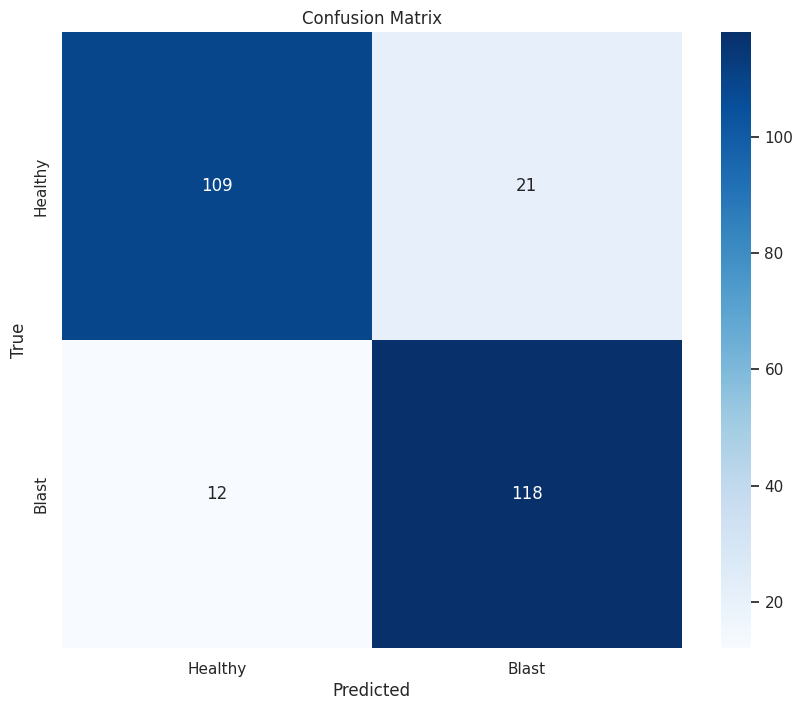

In [105]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['Healthy', 'Blast'])

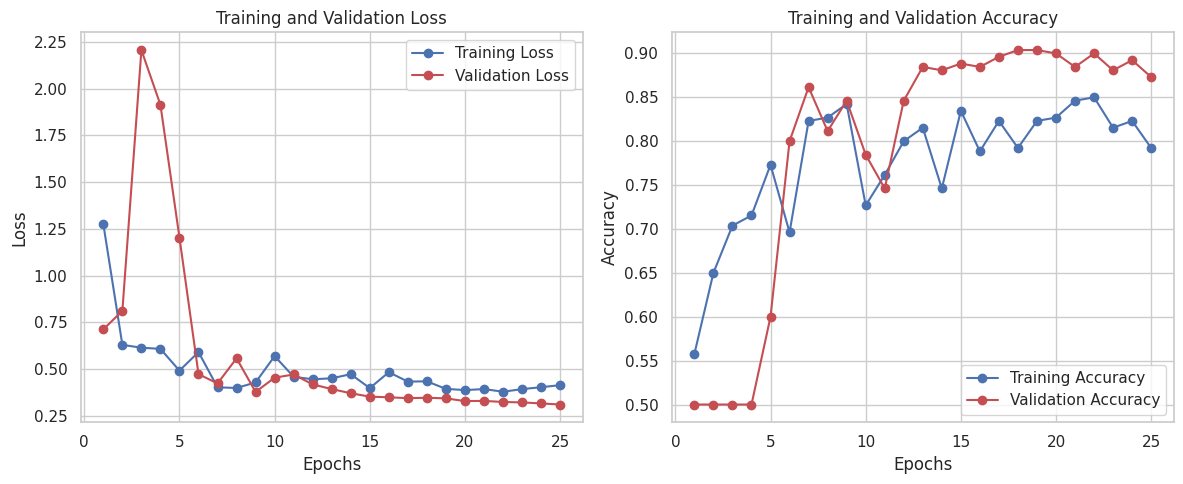

In [106]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

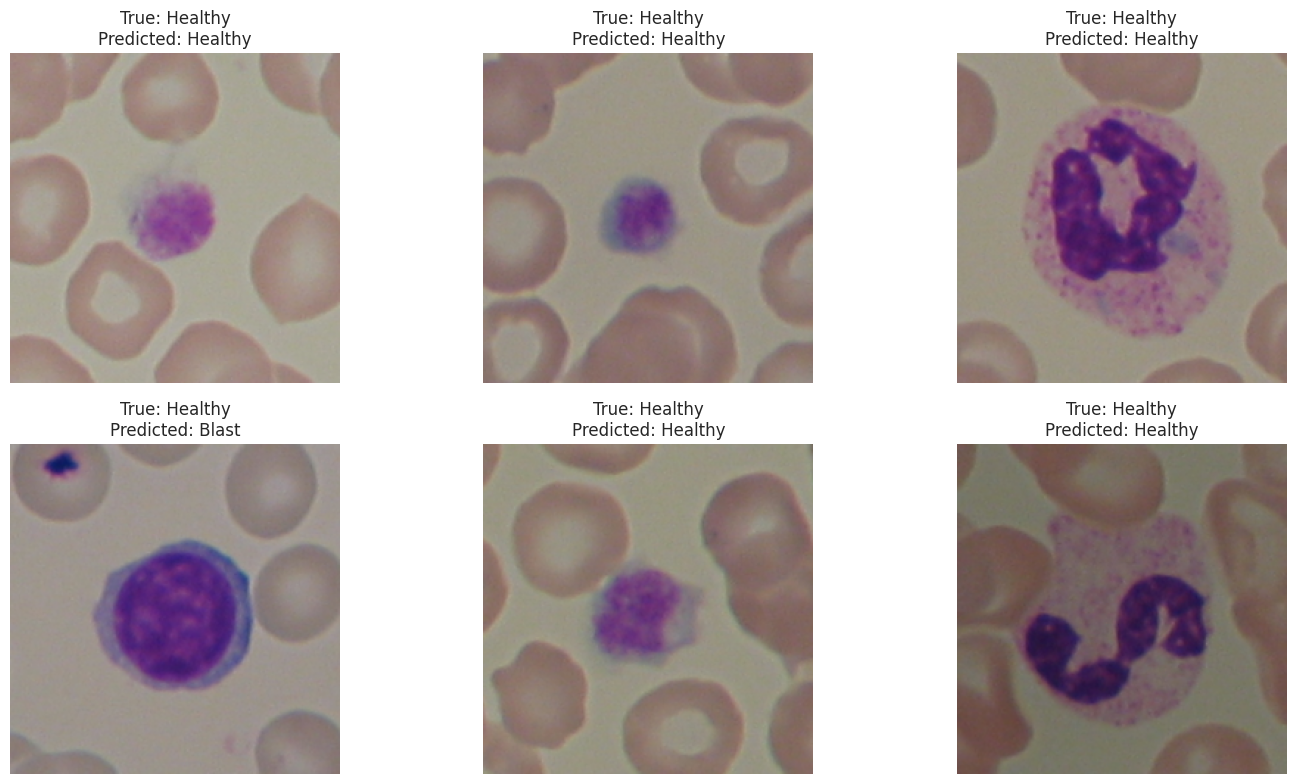

In [107]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Display each image with true and predicted labels
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)  # Un-normalize for visualization
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['Healthy', 'Blast'], num_images=6)